In [2]:
#dependencies 
import numpy as np
import cv2
import os
from tqdm import tqdm

In [5]:
REBUILD_DATA=True

In [6]:
class catsvdogs():
  img_size=50 #standardizing the image dimensions throughout the dataset
  cats='C:/Users/91884/Desktop/Project/cats_dogs/PetImages/Cat' #drive path of folder
  dogs='C:/Users/91884/Desktop/Project/cats_dogs/PetImages/Dog'
  labels={cats:0,dogs:1}
  train=[] #list to append data
  c_count=0 #to count the number of samples of cats
  d_count=0 #to count the number of samples of dogs

  def forging_training_data(self):
    for label in self.labels:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path=os.path.join(label,f) #joining path
          img=cv2.imread(path,0) #reading image
          img=cv2.resize(img,(self.img_size,self.img_size)) #resizing the images, lossy compression
          self.train.append([np.array(img),np.eye(2)[self.labels[label]]]) #2 because we have 2 classes : cat and dog
          if label==self.cats:
            self.c_count+=1
          elif label==self.dogs:
            self.d_count+=1
        except Exception as e:
          pass
    np.random.shuffle(self.train)
    np.save('train.npy',self.train)
    print('Samples of Cats:',self.c_count)
    print('Samples of Dogs:',self.d_count)
if REBUILD_DATA:
  obj=catsvdogs()
  obj.forging_training_data()

  0%|▏                                                                             | 29/12501 [00:00<00:43, 285.17it/s]

C:/Users/91884/Desktop/Project/cats_dogs/PetImages/Cat


  0%|▏                                                                             | 35/12501 [00:00<00:36, 344.06it/s]

C:/Users/91884/Desktop/Project/cats_dogs/PetImages/Dog


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:34<00:00, 358.44it/s]


Samples of Cats: 12476
Samples of Dogs: 12470


In [7]:
#printing the total training data
train=np.load('train.npy',allow_pickle=True)
print(len(train))

24946


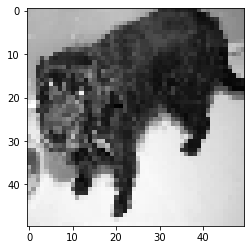

[0. 1.]


In [11]:
#to have a look at our image samples
import matplotlib.pyplot as plt
plt.imshow(train[41][0],cmap='gray')
plt.show()
print(train[41][1]) #printing its class; [0. 1.]-> represents dog

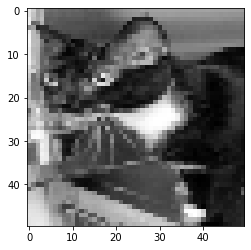

[1. 0.]


In [12]:
plt.imshow(train[11][0],cmap='gray')
plt.show()
print(train[11][1]) #printing its class; [1. 0.]-> represents cat

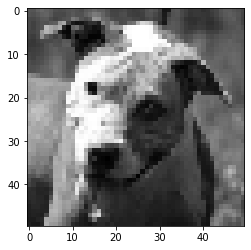

[0. 1.]


In [13]:
plt.imshow(train[2][0],cmap='gray')
plt.show()
print(train[2][1]) #printing its class; [0. 1.]-> represents dog

In [14]:
# deep learning dependencies
import torch
import torch.nn as nn
import torch.nn.functional as f

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,5) # input 1, output 32, kernel size 5
        self.conv2=nn.Conv2d(32,64,5)#output of conv1 is input of conv2 and this goes on
        self.conv3=nn.Conv2d(64,128,5)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.pool3 = nn.MaxPool2d((2, 2))
# commenting out fc layers, replace value with our output
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = self.pool1(x)
        x = f.relu(self.conv2(x))
        x = self.pool2(x)
        x = f.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim=1) # flattening out
        print(x.shape) # printing the shape of the flattened output
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        return f.softmax(x, dim=1)
    
net = Net()
net.forward(torch.randn(1, 1, 50, 50)) # passing a sample input (random)


torch.Size([1, 512])


tensor([[0.5144, 0.4856]], grad_fn=<SoftmaxBackward>)

In [40]:
import torch.optim as optim

optimizer=optim.Adam(net.parameters(),lr=10**-3)
loss=nn.MSELoss()

#normalizing the image pixels
X=torch.Tensor([i[0] for i in train]).view(-1,50,50)
X/=255.0
y=torch.Tensor([i[1] for i in train])

val_per=0.2
val_size=int(len(X)*val_per)
print(val_size)

4989


In [41]:
#training
x_train=X[:-val_size]
y_train=y[:-val_size]


x_test=X[-val_size:]
y_test=y[-val_size:]

print(len(x_train))
print(len(x_test))

19957
4989


In [42]:
#training on cpu so will be taking the epoch count to 3
epochs=3
batch_size=100

for epoch in range(epochs):
    for i in tqdm(range(0,len(x_train),batch_size)):
        x_batch=x_train[i:i+batch_size].view(-1,1,50,50)
        y_batch=y_train[i:i+batch_size]
        
        net.zero_grad()
        outputs=net(x_batch)
        loss_val=loss(outputs,y_batch)
        loss_val.backward()
        optimizer.step()
print(loss_val)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

torch.Size([100, 512])


  0%|▍                                                                                 | 1/200 [00:01<04:33,  1.37s/it]

torch.Size([100, 512])


  2%|█▏                                                                                | 3/200 [00:01<02:41,  1.22it/s]

torch.Size([100, 512])
torch.Size([100, 512])


  2%|█▋                                                                                | 4/200 [00:02<02:09,  1.51it/s]

torch.Size([100, 512])


  3%|██▍                                                                               | 6/200 [00:02<01:32,  2.10it/s]

torch.Size([100, 512])
torch.Size([100, 512])


  4%|██▊                                                                               | 7/200 [00:03<01:21,  2.38it/s]

torch.Size([100, 512])


  4%|███▎                                                                              | 8/200 [00:03<01:13,  2.62it/s]

torch.Size([100, 512])


  4%|███▋                                                                              | 9/200 [00:03<01:08,  2.81it/s]

torch.Size([100, 512])


  6%|████▍                                                                            | 11/200 [00:04<01:01,  3.08it/s]

torch.Size([100, 512])
torch.Size([100, 512])


  6%|████▊                                                                            | 12/200 [00:04<01:03,  2.96it/s]

torch.Size([100, 512])


  7%|█████▋                                                                           | 14/200 [00:05<00:58,  3.20it/s]

torch.Size([100, 512])
torch.Size([100, 512])


  8%|██████                                                                           | 15/200 [00:05<00:58,  3.18it/s]

torch.Size([100, 512])


  8%|██████▍                                                                          | 16/200 [00:05<00:59,  3.09it/s]

torch.Size([100, 512])


  8%|██████▉                                                                          | 17/200 [00:06<00:59,  3.08it/s]

torch.Size([100, 512])


  9%|███████▎                                                                         | 18/200 [00:06<01:00,  3.01it/s]

torch.Size([100, 512])


 10%|███████▋                                                                         | 19/200 [00:06<00:57,  3.13it/s]

torch.Size([100, 512])


 10%|████████                                                                         | 20/200 [00:07<00:55,  3.23it/s]

torch.Size([100, 512])


 10%|████████▌                                                                        | 21/200 [00:07<00:54,  3.30it/s]

torch.Size([100, 512])


 11%|████████▉                                                                        | 22/200 [00:07<00:52,  3.36it/s]

torch.Size([100, 512])


 12%|█████████▎                                                                       | 23/200 [00:08<00:55,  3.21it/s]

torch.Size([100, 512])


 12%|█████████▋                                                                       | 24/200 [00:08<00:58,  3.00it/s]

torch.Size([100, 512])


 12%|██████████▏                                                                      | 25/200 [00:08<01:00,  2.90it/s]

torch.Size([100, 512])


 13%|██████████▌                                                                      | 26/200 [00:09<01:02,  2.80it/s]

torch.Size([100, 512])


 14%|██████████▉                                                                      | 27/200 [00:09<01:01,  2.82it/s]

torch.Size([100, 512])


 14%|███████████▎                                                                     | 28/200 [00:09<00:58,  2.96it/s]

torch.Size([100, 512])


 14%|███████████▋                                                                     | 29/200 [00:10<00:55,  3.09it/s]

torch.Size([100, 512])


 15%|████████████▏                                                                    | 30/200 [00:10<00:53,  3.19it/s]

torch.Size([100, 512])


 16%|████████████▌                                                                    | 31/200 [00:10<00:51,  3.28it/s]

torch.Size([100, 512])


 16%|████████████▉                                                                    | 32/200 [00:11<00:50,  3.34it/s]

torch.Size([100, 512])


 16%|█████████████▎                                                                   | 33/200 [00:11<00:49,  3.38it/s]

torch.Size([100, 512])


 17%|█████████████▊                                                                   | 34/200 [00:11<00:48,  3.41it/s]

torch.Size([100, 512])


 18%|██████████████▌                                                                  | 36/200 [00:12<00:47,  3.45it/s]

torch.Size([100, 512])
torch.Size([100, 512])


 19%|███████████████▍                                                                 | 38/200 [00:12<00:46,  3.50it/s]

torch.Size([100, 512])
torch.Size([100, 512])


 20%|███████████████▊                                                                 | 39/200 [00:13<00:46,  3.46it/s]

torch.Size([100, 512])


 20%|████████████████▏                                                                | 40/200 [00:13<00:46,  3.47it/s]

torch.Size([100, 512])


 20%|████████████████▌                                                                | 41/200 [00:13<00:48,  3.30it/s]

torch.Size([100, 512])


 21%|█████████████████                                                                | 42/200 [00:13<00:47,  3.30it/s]

torch.Size([100, 512])


 22%|█████████████████▍                                                               | 43/200 [00:14<00:47,  3.32it/s]

torch.Size([100, 512])


 22%|█████████████████▊                                                               | 44/200 [00:14<00:46,  3.36it/s]

torch.Size([100, 512])


 22%|██████████████████▏                                                              | 45/200 [00:14<00:45,  3.41it/s]

torch.Size([100, 512])


 23%|██████████████████▋                                                              | 46/200 [00:15<00:44,  3.42it/s]

torch.Size([100, 512])


 24%|███████████████████                                                              | 47/200 [00:15<00:44,  3.45it/s]

torch.Size([100, 512])


 24%|███████████████████▍                                                             | 48/200 [00:15<00:43,  3.48it/s]

torch.Size([100, 512])


 24%|███████████████████▊                                                             | 49/200 [00:15<00:43,  3.47it/s]

torch.Size([100, 512])


 25%|████████████████████▎                                                            | 50/200 [00:16<00:42,  3.49it/s]

torch.Size([100, 512])


 26%|████████████████████▋                                                            | 51/200 [00:16<00:45,  3.29it/s]

torch.Size([100, 512])


 26%|█████████████████████                                                            | 52/200 [00:16<00:44,  3.30it/s]

torch.Size([100, 512])


 26%|█████████████████████▍                                                           | 53/200 [00:17<00:46,  3.19it/s]

torch.Size([100, 512])


 27%|█████████████████████▊                                                           | 54/200 [00:17<00:47,  3.11it/s]

torch.Size([100, 512])


 28%|██████████████████████▋                                                          | 56/200 [00:18<00:44,  3.20it/s]

torch.Size([100, 512])
torch.Size([100, 512])


 28%|███████████████████████                                                          | 57/200 [00:18<00:42,  3.33it/s]

torch.Size([100, 512])


 29%|███████████████████████▍                                                         | 58/200 [00:18<00:41,  3.40it/s]

torch.Size([100, 512])


 30%|███████████████████████▉                                                         | 59/200 [00:19<00:41,  3.36it/s]

torch.Size([100, 512])


 30%|████████████████████████▎                                                        | 60/200 [00:19<00:41,  3.34it/s]

torch.Size([100, 512])


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:41,  3.32it/s]

torch.Size([100, 512])


 31%|█████████████████████████                                                        | 62/200 [00:19<00:41,  3.35it/s]

torch.Size([100, 512])


 32%|█████████████████████████▌                                                       | 63/200 [00:20<00:40,  3.38it/s]

torch.Size([100, 512])


 32%|█████████████████████████▉                                                       | 64/200 [00:20<00:39,  3.43it/s]

torch.Size([100, 512])


 32%|██████████████████████████▎                                                      | 65/200 [00:20<00:41,  3.28it/s]

torch.Size([100, 512])


 33%|██████████████████████████▋                                                      | 66/200 [00:21<00:41,  3.24it/s]

torch.Size([100, 512])


 34%|███████████████████████████▏                                                     | 67/200 [00:21<00:40,  3.31it/s]

torch.Size([100, 512])


 34%|███████████████████████████▌                                                     | 68/200 [00:21<00:39,  3.36it/s]

torch.Size([100, 512])


 34%|███████████████████████████▉                                                     | 69/200 [00:22<00:38,  3.39it/s]

torch.Size([100, 512])


 35%|████████████████████████████▎                                                    | 70/200 [00:22<00:38,  3.42it/s]

torch.Size([100, 512])


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:37,  3.44it/s]

torch.Size([100, 512])


 36%|█████████████████████████████▏                                                   | 72/200 [00:22<00:36,  3.46it/s]

torch.Size([100, 512])


 36%|█████████████████████████████▌                                                   | 73/200 [00:23<00:36,  3.47it/s]

torch.Size([100, 512])


 37%|█████████████████████████████▉                                                   | 74/200 [00:23<00:36,  3.50it/s]

torch.Size([100, 512])


 38%|██████████████████████████████▍                                                  | 75/200 [00:23<00:35,  3.50it/s]

torch.Size([100, 512])


 38%|██████████████████████████████▊                                                  | 76/200 [00:24<00:35,  3.51it/s]

torch.Size([100, 512])


 38%|███████████████████████████████▏                                                 | 77/200 [00:24<00:35,  3.46it/s]

torch.Size([100, 512])


 39%|███████████████████████████████▌                                                 | 78/200 [00:24<00:37,  3.24it/s]

torch.Size([100, 512])


 40%|███████████████████████████████▉                                                 | 79/200 [00:25<00:37,  3.23it/s]

torch.Size([100, 512])


 40%|████████████████████████████████▍                                                | 80/200 [00:25<00:38,  3.13it/s]

torch.Size([100, 512])


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:38,  3.10it/s]

torch.Size([100, 512])


 41%|█████████████████████████████████▏                                               | 82/200 [00:25<00:37,  3.15it/s]

torch.Size([100, 512])


 42%|█████████████████████████████████▌                                               | 83/200 [00:26<00:37,  3.14it/s]

torch.Size([100, 512])


 42%|██████████████████████████████████                                               | 84/200 [00:26<00:36,  3.19it/s]

torch.Size([100, 512])


 42%|██████████████████████████████████▍                                              | 85/200 [00:26<00:35,  3.24it/s]

torch.Size([100, 512])


 43%|██████████████████████████████████▊                                              | 86/200 [00:27<00:35,  3.24it/s]

torch.Size([100, 512])


 44%|███████████████████████████████████▏                                             | 87/200 [00:27<00:34,  3.25it/s]

torch.Size([100, 512])


 44%|███████████████████████████████████▋                                             | 88/200 [00:27<00:35,  3.17it/s]

torch.Size([100, 512])


 44%|████████████████████████████████████                                             | 89/200 [00:28<00:34,  3.18it/s]

torch.Size([100, 512])


 45%|████████████████████████████████████▍                                            | 90/200 [00:28<00:33,  3.24it/s]

torch.Size([100, 512])


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:33,  3.28it/s]

torch.Size([100, 512])


 46%|█████████████████████████████████████▎                                           | 92/200 [00:29<00:33,  3.24it/s]

torch.Size([100, 512])


 46%|█████████████████████████████████████▋                                           | 93/200 [00:29<00:33,  3.22it/s]

torch.Size([100, 512])


 47%|██████████████████████████████████████                                           | 94/200 [00:29<00:32,  3.24it/s]

torch.Size([100, 512])


 48%|██████████████████████████████████████▍                                          | 95/200 [00:30<00:32,  3.23it/s]

torch.Size([100, 512])


 48%|██████████████████████████████████████▉                                          | 96/200 [00:30<00:32,  3.24it/s]

torch.Size([100, 512])


 48%|███████████████████████████████████████▎                                         | 97/200 [00:30<00:31,  3.23it/s]

torch.Size([100, 512])


 49%|███████████████████████████████████████▋                                         | 98/200 [00:30<00:31,  3.19it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████                                         | 99/200 [00:31<00:32,  3.07it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████                                        | 100/200 [00:31<00:31,  3.15it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:31,  3.15it/s]

torch.Size([100, 512])


 51%|████████████████████████████████████████▊                                       | 102/200 [00:32<00:31,  3.11it/s]

torch.Size([100, 512])


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:32<00:31,  3.12it/s]

torch.Size([100, 512])


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:32<00:30,  3.15it/s]

torch.Size([100, 512])


 52%|██████████████████████████████████████████                                      | 105/200 [00:33<00:29,  3.17it/s]

torch.Size([100, 512])


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:33<00:29,  3.15it/s]

torch.Size([100, 512])


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:34<00:29,  3.14it/s]

torch.Size([100, 512])
torch.Size([100, 512])


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:34<00:28,  3.19it/s]

torch.Size([100, 512])


 55%|████████████████████████████████████████████                                    | 110/200 [00:34<00:28,  3.20it/s]

torch.Size([100, 512])


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:27,  3.23it/s]

torch.Size([100, 512])


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:35<00:27,  3.21it/s]

torch.Size([100, 512])


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:35<00:27,  3.19it/s]

torch.Size([100, 512])


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:36<00:26,  3.19it/s]

torch.Size([100, 512])


 57%|██████████████████████████████████████████████                                  | 115/200 [00:36<00:26,  3.25it/s]

torch.Size([100, 512])


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:36<00:25,  3.23it/s]

torch.Size([100, 512])


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:36<00:25,  3.25it/s]

torch.Size([100, 512])


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:37<00:24,  3.28it/s]

torch.Size([100, 512])


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:37<00:24,  3.28it/s]

torch.Size([100, 512])


 60%|████████████████████████████████████████████████                                | 120/200 [00:37<00:24,  3.30it/s]

torch.Size([100, 512])


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:24,  3.29it/s]

torch.Size([100, 512])


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:38<00:23,  3.33it/s]

torch.Size([100, 512])


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:38<00:23,  3.33it/s]

torch.Size([100, 512])


 62%|██████████████████████████████████████████████████                              | 125/200 [00:39<00:22,  3.35it/s]

torch.Size([100, 512])
torch.Size([100, 512])


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:39<00:22,  3.35it/s]

torch.Size([100, 512])


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:39<00:21,  3.32it/s]

torch.Size([100, 512])


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:40<00:21,  3.30it/s]

torch.Size([100, 512])


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:40<00:21,  3.33it/s]

torch.Size([100, 512])


 65%|████████████████████████████████████████████████████                            | 130/200 [00:40<00:21,  3.31it/s]

torch.Size([100, 512])


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:20,  3.31it/s]

torch.Size([100, 512])


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:41<00:20,  3.33it/s]

torch.Size([100, 512])


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:41<00:20,  3.31it/s]

torch.Size([100, 512])


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:42<00:19,  3.31it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:42<00:19,  3.29it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:42<00:19,  3.32it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:42<00:19,  3.31it/s]

torch.Size([100, 512])


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:43<00:18,  3.31it/s]

torch.Size([100, 512])


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:43<00:18,  3.31it/s]

torch.Size([100, 512])


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:43<00:18,  3.32it/s]

torch.Size([100, 512])


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:17,  3.36it/s]

torch.Size([100, 512])


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:44<00:17,  3.31it/s]

torch.Size([100, 512])


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:44<00:17,  3.30it/s]

torch.Size([100, 512])


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:45<00:17,  3.25it/s]

torch.Size([100, 512])


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:45<00:17,  3.11it/s]

torch.Size([100, 512])


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:45<00:17,  3.10it/s]

torch.Size([100, 512])


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:46<00:16,  3.15it/s]

torch.Size([100, 512])


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:46<00:16,  3.19it/s]

torch.Size([100, 512])


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:46<00:15,  3.24it/s]

torch.Size([100, 512])


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:46<00:15,  3.26it/s]

torch.Size([100, 512])


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:14,  3.27it/s]

torch.Size([100, 512])


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:47<00:14,  3.29it/s]

torch.Size([100, 512])


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:47<00:14,  3.29it/s]

torch.Size([100, 512])


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:48<00:13,  3.32it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:48<00:13,  3.33it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:48<00:13,  3.35it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:49<00:13,  3.27it/s]

torch.Size([100, 512])


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:49<00:13,  3.08it/s]

torch.Size([100, 512])


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:49<00:13,  3.02it/s]

torch.Size([100, 512])


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:50<00:12,  3.08it/s]

torch.Size([100, 512])


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.11it/s]

torch.Size([100, 512])


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:50<00:12,  3.12it/s]

torch.Size([100, 512])


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [00:51<00:11,  3.14it/s]

torch.Size([100, 512])


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:51<00:11,  3.19it/s]

torch.Size([100, 512])


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:51<00:10,  3.22it/s]

torch.Size([100, 512])


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:51<00:10,  3.19it/s]

torch.Size([100, 512])


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:52<00:10,  3.05it/s]

torch.Size([100, 512])


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:52<00:11,  2.88it/s]

torch.Size([100, 512])


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [00:53<00:10,  3.00it/s]

torch.Size([100, 512])


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [00:53<00:10,  2.99it/s]

torch.Size([100, 512])


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:09,  3.11it/s]

torch.Size([100, 512])


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [00:53<00:08,  3.18it/s]

torch.Size([100, 512])


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [00:54<00:08,  3.22it/s]

torch.Size([100, 512])


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [00:54<00:08,  3.22it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [00:54<00:07,  3.26it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [00:55<00:07,  3.28it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [00:55<00:07,  3.28it/s]

torch.Size([100, 512])


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [00:55<00:06,  3.26it/s]

torch.Size([100, 512])


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [00:56<00:06,  3.31it/s]

torch.Size([100, 512])


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [00:56<00:06,  3.30it/s]

torch.Size([100, 512])


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.29it/s]

torch.Size([100, 512])


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [00:57<00:05,  3.19it/s]

torch.Size([100, 512])


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [00:57<00:05,  3.20it/s]

torch.Size([100, 512])


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:57<00:04,  3.24it/s]

torch.Size([100, 512])


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [00:57<00:04,  3.24it/s]

torch.Size([100, 512])


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [00:58<00:04,  3.21it/s]

torch.Size([100, 512])


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [00:58<00:04,  3.17it/s]

torch.Size([100, 512])


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [00:58<00:03,  3.20it/s]

torch.Size([100, 512])


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [00:59<00:03,  3.18it/s]

torch.Size([100, 512])


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [00:59<00:03,  3.17it/s]

torch.Size([100, 512])


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.15it/s]

torch.Size([100, 512])


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:00<00:02,  3.17it/s]

torch.Size([100, 512])


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:00<00:02,  3.18it/s]

torch.Size([100, 512])


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:00<00:01,  3.23it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:01<00:01,  3.02it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:01<00:01,  3.09it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:01<00:00,  3.12it/s]

torch.Size([100, 512])


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:02<00:00,  2.68it/s]

torch.Size([100, 512])


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

torch.Size([57, 512])
torch.Size([100, 512])


  0%|▍                                                                                 | 1/200 [00:00<01:09,  2.86it/s]

torch.Size([100, 512])


  1%|▊                                                                                 | 2/200 [00:00<01:10,  2.82it/s]

torch.Size([100, 512])


  2%|█▏                                                                                | 3/200 [00:01<01:06,  2.97it/s]

torch.Size([100, 512])


  2%|█▋                                                                                | 4/200 [00:01<01:03,  3.08it/s]

torch.Size([100, 512])


  2%|██                                                                                | 5/200 [00:01<01:01,  3.15it/s]

torch.Size([100, 512])


  3%|██▍                                                                               | 6/200 [00:01<00:59,  3.24it/s]

torch.Size([100, 512])


  4%|██▊                                                                               | 7/200 [00:02<00:58,  3.29it/s]

torch.Size([100, 512])


  4%|███▎                                                                              | 8/200 [00:02<00:58,  3.30it/s]

torch.Size([100, 512])


  4%|███▋                                                                              | 9/200 [00:02<00:58,  3.29it/s]

torch.Size([100, 512])


  5%|████                                                                             | 10/200 [00:03<00:57,  3.30it/s]

torch.Size([100, 512])


  6%|████▍                                                                            | 11/200 [00:03<00:57,  3.30it/s]

torch.Size([100, 512])


  6%|████▊                                                                            | 12/200 [00:03<00:56,  3.32it/s]

torch.Size([100, 512])


  6%|█████▎                                                                           | 13/200 [00:04<00:56,  3.29it/s]

torch.Size([100, 512])


  7%|█████▋                                                                           | 14/200 [00:04<00:56,  3.31it/s]

torch.Size([100, 512])


  8%|██████                                                                           | 15/200 [00:04<00:55,  3.33it/s]

torch.Size([100, 512])


  8%|██████▍                                                                          | 16/200 [00:04<00:57,  3.22it/s]

torch.Size([100, 512])


  8%|██████▉                                                                          | 17/200 [00:05<01:02,  2.92it/s]

torch.Size([100, 512])


  9%|███████▎                                                                         | 18/200 [00:05<01:05,  2.79it/s]

torch.Size([100, 512])


 10%|███████▋                                                                         | 19/200 [00:06<01:07,  2.69it/s]

torch.Size([100, 512])


 10%|████████                                                                         | 20/200 [00:06<01:07,  2.65it/s]

torch.Size([100, 512])


 10%|████████▌                                                                        | 21/200 [00:06<01:08,  2.62it/s]

torch.Size([100, 512])


 11%|████████▉                                                                        | 22/200 [00:07<01:08,  2.60it/s]

torch.Size([100, 512])


 12%|█████████▎                                                                       | 23/200 [00:07<01:09,  2.56it/s]

torch.Size([100, 512])


 12%|█████████▋                                                                       | 24/200 [00:08<01:08,  2.55it/s]

torch.Size([100, 512])


 12%|██████████▏                                                                      | 25/200 [00:08<01:06,  2.64it/s]

torch.Size([100, 512])


 13%|██████████▌                                                                      | 26/200 [00:08<01:04,  2.69it/s]

torch.Size([100, 512])


 14%|██████████▉                                                                      | 27/200 [00:09<01:02,  2.75it/s]

torch.Size([100, 512])


 14%|███████████▎                                                                     | 28/200 [00:09<01:02,  2.77it/s]

torch.Size([100, 512])


 14%|███████████▋                                                                     | 29/200 [00:09<01:01,  2.80it/s]

torch.Size([100, 512])


 15%|████████████▏                                                                    | 30/200 [00:10<01:00,  2.82it/s]

torch.Size([100, 512])


 16%|████████████▌                                                                    | 31/200 [00:10<00:59,  2.83it/s]

torch.Size([100, 512])


 16%|████████████▉                                                                    | 32/200 [00:10<00:59,  2.82it/s]

torch.Size([100, 512])


 16%|█████████████▎                                                                   | 33/200 [00:11<00:58,  2.84it/s]

torch.Size([100, 512])


 17%|█████████████▊                                                                   | 34/200 [00:11<00:58,  2.84it/s]

torch.Size([100, 512])


 18%|██████████████▏                                                                  | 35/200 [00:11<00:57,  2.86it/s]

torch.Size([100, 512])


 18%|██████████████▌                                                                  | 36/200 [00:12<00:57,  2.83it/s]

torch.Size([100, 512])


 18%|██████████████▉                                                                  | 37/200 [00:12<00:57,  2.83it/s]

torch.Size([100, 512])


 19%|███████████████▍                                                                 | 38/200 [00:13<00:57,  2.82it/s]

torch.Size([100, 512])


 20%|███████████████▊                                                                 | 39/200 [00:13<00:57,  2.82it/s]

torch.Size([100, 512])


 20%|████████████████▏                                                                | 40/200 [00:13<00:56,  2.82it/s]

torch.Size([100, 512])


 20%|████████████████▌                                                                | 41/200 [00:14<00:56,  2.82it/s]

torch.Size([100, 512])


 21%|█████████████████                                                                | 42/200 [00:14<00:55,  2.83it/s]

torch.Size([100, 512])


 22%|█████████████████▍                                                               | 43/200 [00:14<00:55,  2.82it/s]

torch.Size([100, 512])


 22%|█████████████████▊                                                               | 44/200 [00:15<00:55,  2.83it/s]

torch.Size([100, 512])


 22%|██████████████████▏                                                              | 45/200 [00:15<00:54,  2.85it/s]

torch.Size([100, 512])


 23%|██████████████████▋                                                              | 46/200 [00:15<00:54,  2.84it/s]

torch.Size([100, 512])


 24%|███████████████████                                                              | 47/200 [00:16<00:53,  2.83it/s]

torch.Size([100, 512])


 24%|███████████████████▍                                                             | 48/200 [00:16<00:54,  2.81it/s]

torch.Size([100, 512])


 24%|███████████████████▊                                                             | 49/200 [00:16<00:53,  2.84it/s]

torch.Size([100, 512])


 25%|████████████████████▎                                                            | 50/200 [00:17<00:52,  2.84it/s]

torch.Size([100, 512])


 26%|████████████████████▋                                                            | 51/200 [00:17<00:52,  2.84it/s]

torch.Size([100, 512])


 26%|█████████████████████                                                            | 52/200 [00:17<00:52,  2.84it/s]

torch.Size([100, 512])


 26%|█████████████████████▍                                                           | 53/200 [00:18<00:51,  2.84it/s]

torch.Size([100, 512])


 27%|█████████████████████▊                                                           | 54/200 [00:18<00:51,  2.86it/s]

torch.Size([100, 512])


 28%|██████████████████████▎                                                          | 55/200 [00:19<00:50,  2.85it/s]

torch.Size([100, 512])


 28%|██████████████████████▋                                                          | 56/200 [00:19<00:50,  2.84it/s]

torch.Size([100, 512])


 28%|███████████████████████                                                          | 57/200 [00:19<00:49,  2.87it/s]

torch.Size([100, 512])


 29%|███████████████████████▍                                                         | 58/200 [00:20<00:50,  2.84it/s]

torch.Size([100, 512])


 30%|███████████████████████▉                                                         | 59/200 [00:20<00:49,  2.85it/s]

torch.Size([100, 512])


 30%|████████████████████████▎                                                        | 60/200 [00:20<00:49,  2.85it/s]

torch.Size([100, 512])


 30%|████████████████████████▋                                                        | 61/200 [00:21<00:48,  2.84it/s]

torch.Size([100, 512])


 31%|█████████████████████████                                                        | 62/200 [00:21<00:48,  2.83it/s]

torch.Size([100, 512])


 32%|█████████████████████████▌                                                       | 63/200 [00:21<00:48,  2.83it/s]

torch.Size([100, 512])


 32%|█████████████████████████▉                                                       | 64/200 [00:22<00:48,  2.83it/s]

torch.Size([100, 512])


 32%|██████████████████████████▎                                                      | 65/200 [00:22<00:47,  2.83it/s]

torch.Size([100, 512])


 33%|██████████████████████████▋                                                      | 66/200 [00:22<00:47,  2.84it/s]

torch.Size([100, 512])


 34%|███████████████████████████▏                                                     | 67/200 [00:23<00:46,  2.84it/s]

torch.Size([100, 512])


 34%|███████████████████████████▌                                                     | 68/200 [00:23<00:46,  2.85it/s]

torch.Size([100, 512])


 34%|███████████████████████████▉                                                     | 69/200 [00:23<00:45,  2.86it/s]

torch.Size([100, 512])


 35%|████████████████████████████▎                                                    | 70/200 [00:24<00:45,  2.85it/s]

torch.Size([100, 512])


 36%|████████████████████████████▊                                                    | 71/200 [00:24<00:44,  2.87it/s]

torch.Size([100, 512])


 36%|█████████████████████████████▏                                                   | 72/200 [00:25<00:44,  2.85it/s]

torch.Size([100, 512])


 36%|█████████████████████████████▌                                                   | 73/200 [00:25<00:44,  2.84it/s]

torch.Size([100, 512])


 37%|█████████████████████████████▉                                                   | 74/200 [00:25<00:44,  2.84it/s]

torch.Size([100, 512])


 38%|██████████████████████████████▍                                                  | 75/200 [00:26<00:44,  2.84it/s]

torch.Size([100, 512])


 38%|██████████████████████████████▊                                                  | 76/200 [00:26<00:43,  2.85it/s]

torch.Size([100, 512])


 38%|███████████████████████████████▏                                                 | 77/200 [00:26<00:43,  2.84it/s]

torch.Size([100, 512])


 39%|███████████████████████████████▌                                                 | 78/200 [00:27<00:42,  2.84it/s]

torch.Size([100, 512])


 40%|███████████████████████████████▉                                                 | 79/200 [00:27<00:42,  2.82it/s]

torch.Size([100, 512])


 40%|████████████████████████████████▍                                                | 80/200 [00:27<00:42,  2.86it/s]

torch.Size([100, 512])


 40%|████████████████████████████████▊                                                | 81/200 [00:28<00:41,  2.85it/s]

torch.Size([100, 512])


 41%|█████████████████████████████████▏                                               | 82/200 [00:28<00:40,  2.88it/s]

torch.Size([100, 512])


 42%|█████████████████████████████████▌                                               | 83/200 [00:28<00:40,  2.89it/s]

torch.Size([100, 512])


 42%|██████████████████████████████████                                               | 84/200 [00:29<00:40,  2.87it/s]

torch.Size([100, 512])


 42%|██████████████████████████████████▍                                              | 85/200 [00:29<00:40,  2.85it/s]

torch.Size([100, 512])


 43%|██████████████████████████████████▊                                              | 86/200 [00:29<00:39,  2.85it/s]

torch.Size([100, 512])


 44%|███████████████████████████████████▏                                             | 87/200 [00:30<00:39,  2.87it/s]

torch.Size([100, 512])


 44%|███████████████████████████████████▋                                             | 88/200 [00:30<00:38,  2.87it/s]

torch.Size([100, 512])


 44%|████████████████████████████████████                                             | 89/200 [00:30<00:38,  2.88it/s]

torch.Size([100, 512])


 45%|████████████████████████████████████▍                                            | 90/200 [00:31<00:38,  2.89it/s]

torch.Size([100, 512])


 46%|████████████████████████████████████▊                                            | 91/200 [00:31<00:38,  2.87it/s]

torch.Size([100, 512])


 46%|█████████████████████████████████████▎                                           | 92/200 [00:32<00:38,  2.81it/s]

torch.Size([100, 512])


 46%|█████████████████████████████████████▋                                           | 93/200 [00:32<00:37,  2.82it/s]

torch.Size([100, 512])


 47%|██████████████████████████████████████                                           | 94/200 [00:32<00:37,  2.81it/s]

torch.Size([100, 512])


 48%|██████████████████████████████████████▍                                          | 95/200 [00:33<00:37,  2.82it/s]

torch.Size([100, 512])


 48%|██████████████████████████████████████▉                                          | 96/200 [00:33<00:36,  2.84it/s]

torch.Size([100, 512])


 48%|███████████████████████████████████████▎                                         | 97/200 [00:33<00:36,  2.83it/s]

torch.Size([100, 512])


 49%|███████████████████████████████████████▋                                         | 98/200 [00:34<00:35,  2.86it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████                                         | 99/200 [00:34<00:35,  2.86it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████                                        | 100/200 [00:34<00:34,  2.87it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████▍                                       | 101/200 [00:35<00:34,  2.87it/s]

torch.Size([100, 512])


 51%|████████████████████████████████████████▊                                       | 102/200 [00:35<00:34,  2.87it/s]

torch.Size([100, 512])


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:35<00:33,  2.88it/s]

torch.Size([100, 512])


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:36<00:33,  2.86it/s]

torch.Size([100, 512])


 52%|██████████████████████████████████████████                                      | 105/200 [00:36<00:33,  2.88it/s]

torch.Size([100, 512])


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:36<00:32,  2.88it/s]

torch.Size([100, 512])


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:37<00:32,  2.86it/s]

torch.Size([100, 512])


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:37<00:32,  2.87it/s]

torch.Size([100, 512])


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:37<00:31,  2.86it/s]

torch.Size([100, 512])


 55%|████████████████████████████████████████████                                    | 110/200 [00:38<00:31,  2.87it/s]

torch.Size([100, 512])


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:38<00:31,  2.85it/s]

torch.Size([100, 512])


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:39<00:30,  2.86it/s]

torch.Size([100, 512])


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:39<00:30,  2.83it/s]

torch.Size([100, 512])


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:39<00:30,  2.85it/s]

torch.Size([100, 512])


 57%|██████████████████████████████████████████████                                  | 115/200 [00:40<00:30,  2.83it/s]

torch.Size([100, 512])


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:40<00:29,  2.84it/s]

torch.Size([100, 512])


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:40<00:29,  2.83it/s]

torch.Size([100, 512])


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:41<00:29,  2.81it/s]

torch.Size([100, 512])


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:41<00:28,  2.82it/s]

torch.Size([100, 512])


 60%|████████████████████████████████████████████████                                | 120/200 [00:41<00:28,  2.83it/s]

torch.Size([100, 512])


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:42<00:27,  2.83it/s]

torch.Size([100, 512])


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:42<00:27,  2.82it/s]

torch.Size([100, 512])


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:42<00:27,  2.82it/s]

torch.Size([100, 512])


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:43<00:26,  2.84it/s]

torch.Size([100, 512])


 62%|██████████████████████████████████████████████████                              | 125/200 [00:43<00:26,  2.83it/s]

torch.Size([100, 512])


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:43<00:26,  2.83it/s]

torch.Size([100, 512])


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:44<00:25,  2.81it/s]

torch.Size([100, 512])


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:44<00:25,  2.82it/s]

torch.Size([100, 512])


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:45<00:25,  2.84it/s]

torch.Size([100, 512])


 65%|████████████████████████████████████████████████████                            | 130/200 [00:45<00:24,  2.82it/s]

torch.Size([100, 512])


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:45<00:24,  2.80it/s]

torch.Size([100, 512])


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:46<00:24,  2.81it/s]

torch.Size([100, 512])


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:46<00:23,  2.84it/s]

torch.Size([100, 512])


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:46<00:23,  2.84it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:47<00:22,  2.91it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:47<00:22,  2.80it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:47<00:23,  2.67it/s]

torch.Size([100, 512])


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:48<00:23,  2.64it/s]

torch.Size([100, 512])


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:48<00:23,  2.63it/s]

torch.Size([100, 512])


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:49<00:23,  2.59it/s]

torch.Size([100, 512])


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:49<00:22,  2.58it/s]

torch.Size([100, 512])


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:49<00:22,  2.57it/s]

torch.Size([100, 512])


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:50<00:22,  2.52it/s]

torch.Size([100, 512])


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:50<00:21,  2.58it/s]

torch.Size([100, 512])


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:51<00:20,  2.67it/s]

torch.Size([100, 512])


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:51<00:20,  2.69it/s]

torch.Size([100, 512])


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:51<00:19,  2.72it/s]

torch.Size([100, 512])


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:52<00:18,  2.75it/s]

torch.Size([100, 512])


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:52<00:18,  2.78it/s]

torch.Size([100, 512])


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:52<00:17,  2.78it/s]

torch.Size([100, 512])


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:53<00:17,  2.78it/s]

torch.Size([100, 512])


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:53<00:17,  2.81it/s]

torch.Size([100, 512])


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:53<00:16,  2.83it/s]

torch.Size([100, 512])


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:54<00:16,  2.84it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:54<00:15,  2.84it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:54<00:15,  2.84it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:55<00:15,  2.85it/s]

torch.Size([100, 512])


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:55<00:14,  2.83it/s]

torch.Size([100, 512])


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:55<00:14,  2.83it/s]

torch.Size([100, 512])


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:56<00:14,  2.84it/s]

torch.Size([100, 512])


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:56<00:13,  2.85it/s]

torch.Size([100, 512])


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:57<00:13,  2.86it/s]

torch.Size([100, 512])


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [00:57<00:13,  2.84it/s]

torch.Size([100, 512])


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:57<00:12,  2.81it/s]

torch.Size([100, 512])


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:58<00:12,  2.85it/s]

torch.Size([100, 512])


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:58<00:11,  2.86it/s]

torch.Size([100, 512])


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:58<00:11,  2.86it/s]

torch.Size([100, 512])


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:59<00:11,  2.85it/s]

torch.Size([100, 512])


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [00:59<00:10,  2.86it/s]

torch.Size([100, 512])


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [00:59<00:10,  2.82it/s]

torch.Size([100, 512])


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:00<00:10,  2.81it/s]

torch.Size([100, 512])


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:00<00:10,  2.79it/s]

torch.Size([100, 512])


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [01:00<00:09,  2.81it/s]

torch.Size([100, 512])


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:01<00:09,  2.81it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:01<00:09,  2.77it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:02<00:08,  2.76it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:02<00:08,  2.76it/s]

torch.Size([100, 512])


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:02<00:08,  2.74it/s]

torch.Size([100, 512])


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:03<00:07,  2.74it/s]

torch.Size([100, 512])


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:03<00:07,  2.66it/s]

torch.Size([100, 512])


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:03<00:07,  2.66it/s]

torch.Size([100, 512])


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:04<00:06,  2.69it/s]

torch.Size([100, 512])


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:04<00:06,  2.73it/s]

torch.Size([100, 512])


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:04<00:05,  2.75it/s]

torch.Size([100, 512])


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:05<00:05,  2.75it/s]

torch.Size([100, 512])


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:05<00:05,  2.78it/s]

torch.Size([100, 512])


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:06<00:04,  2.83it/s]

torch.Size([100, 512])


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:06<00:04,  2.82it/s]

torch.Size([100, 512])


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:06<00:03,  2.80it/s]

torch.Size([100, 512])


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:07<00:03,  2.80it/s]

torch.Size([100, 512])


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:07<00:03,  2.80it/s]

torch.Size([100, 512])


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:07<00:02,  2.82it/s]

torch.Size([100, 512])


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:08<00:02,  2.82it/s]

torch.Size([100, 512])


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:08<00:02,  2.81it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:08<00:01,  2.81it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:09<00:01,  2.82it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:09<00:01,  2.83it/s]

torch.Size([100, 512])


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:09<00:00,  2.81it/s]

torch.Size([100, 512])


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

torch.Size([57, 512])
torch.Size([100, 512])


  0%|▍                                                                                 | 1/200 [00:00<01:14,  2.66it/s]

torch.Size([100, 512])


  1%|▊                                                                                 | 2/200 [00:00<01:09,  2.83it/s]

torch.Size([100, 512])


  2%|█▏                                                                                | 3/200 [00:00<01:07,  2.94it/s]

torch.Size([100, 512])


  2%|█▋                                                                                | 4/200 [00:01<01:04,  3.03it/s]

torch.Size([100, 512])


  2%|██                                                                                | 5/200 [00:01<01:07,  2.91it/s]

torch.Size([100, 512])


  3%|██▍                                                                               | 6/200 [00:02<01:11,  2.71it/s]

torch.Size([100, 512])


  4%|██▊                                                                               | 7/200 [00:02<01:11,  2.69it/s]

torch.Size([100, 512])


  4%|███▎                                                                              | 8/200 [00:02<01:13,  2.63it/s]

torch.Size([100, 512])


  4%|███▋                                                                              | 9/200 [00:03<01:13,  2.58it/s]

torch.Size([100, 512])


  5%|████                                                                             | 10/200 [00:03<01:13,  2.58it/s]

torch.Size([100, 512])


  6%|████▍                                                                            | 11/200 [00:04<01:13,  2.56it/s]

torch.Size([100, 512])


  6%|████▊                                                                            | 12/200 [00:04<01:13,  2.56it/s]

torch.Size([100, 512])


  6%|█████▎                                                                           | 13/200 [00:04<01:12,  2.57it/s]

torch.Size([100, 512])


  7%|█████▋                                                                           | 14/200 [00:05<01:10,  2.65it/s]

torch.Size([100, 512])


  8%|██████                                                                           | 15/200 [00:05<01:08,  2.71it/s]

torch.Size([100, 512])


  8%|██████▍                                                                          | 16/200 [00:05<01:07,  2.74it/s]

torch.Size([100, 512])


  8%|██████▉                                                                          | 17/200 [00:06<01:05,  2.78it/s]

torch.Size([100, 512])


  9%|███████▎                                                                         | 18/200 [00:06<01:05,  2.77it/s]

torch.Size([100, 512])


 10%|███████▋                                                                         | 19/200 [00:06<01:04,  2.80it/s]

torch.Size([100, 512])


 10%|████████                                                                         | 20/200 [00:07<01:04,  2.79it/s]

torch.Size([100, 512])


 10%|████████▌                                                                        | 21/200 [00:07<01:03,  2.80it/s]

torch.Size([100, 512])


 11%|████████▉                                                                        | 22/200 [00:08<01:03,  2.79it/s]

torch.Size([100, 512])


 12%|█████████▎                                                                       | 23/200 [00:08<01:02,  2.82it/s]

torch.Size([100, 512])


 12%|█████████▋                                                                       | 24/200 [00:08<01:02,  2.81it/s]

torch.Size([100, 512])


 12%|██████████▏                                                                      | 25/200 [00:09<01:02,  2.82it/s]

torch.Size([100, 512])


 13%|██████████▌                                                                      | 26/200 [00:09<01:01,  2.83it/s]

torch.Size([100, 512])


 14%|██████████▉                                                                      | 27/200 [00:09<01:01,  2.83it/s]

torch.Size([100, 512])


 14%|███████████▎                                                                     | 28/200 [00:10<01:00,  2.85it/s]

torch.Size([100, 512])


 14%|███████████▋                                                                     | 29/200 [00:10<00:59,  2.85it/s]

torch.Size([100, 512])


 15%|████████████▏                                                                    | 30/200 [00:10<00:59,  2.85it/s]

torch.Size([100, 512])


 16%|████████████▌                                                                    | 31/200 [00:11<01:00,  2.80it/s]

torch.Size([100, 512])


 16%|████████████▉                                                                    | 32/200 [00:11<00:59,  2.82it/s]

torch.Size([100, 512])


 16%|█████████████▎                                                                   | 33/200 [00:11<00:59,  2.82it/s]

torch.Size([100, 512])


 17%|█████████████▊                                                                   | 34/200 [00:12<00:58,  2.84it/s]

torch.Size([100, 512])


 18%|██████████████▏                                                                  | 35/200 [00:12<00:58,  2.82it/s]

torch.Size([100, 512])


 18%|██████████████▌                                                                  | 36/200 [00:12<00:58,  2.82it/s]

torch.Size([100, 512])


 18%|██████████████▉                                                                  | 37/200 [00:13<00:57,  2.83it/s]

torch.Size([100, 512])


 19%|███████████████▍                                                                 | 38/200 [00:13<00:56,  2.84it/s]

torch.Size([100, 512])


 20%|███████████████▊                                                                 | 39/200 [00:14<00:56,  2.86it/s]

torch.Size([100, 512])


 20%|████████████████▏                                                                | 40/200 [00:14<00:55,  2.87it/s]

torch.Size([100, 512])


 20%|████████████████▌                                                                | 41/200 [00:14<00:55,  2.84it/s]

torch.Size([100, 512])


 21%|█████████████████                                                                | 42/200 [00:15<00:55,  2.87it/s]

torch.Size([100, 512])


 22%|█████████████████▍                                                               | 43/200 [00:15<00:55,  2.84it/s]

torch.Size([100, 512])


 22%|█████████████████▊                                                               | 44/200 [00:15<00:54,  2.85it/s]

torch.Size([100, 512])


 22%|██████████████████▏                                                              | 45/200 [00:16<00:54,  2.83it/s]

torch.Size([100, 512])


 23%|██████████████████▋                                                              | 46/200 [00:16<00:54,  2.83it/s]

torch.Size([100, 512])


 24%|███████████████████                                                              | 47/200 [00:16<00:54,  2.83it/s]

torch.Size([100, 512])


 24%|███████████████████▍                                                             | 48/200 [00:17<00:53,  2.84it/s]

torch.Size([100, 512])


 24%|███████████████████▊                                                             | 49/200 [00:17<00:53,  2.82it/s]

torch.Size([100, 512])


 25%|████████████████████▎                                                            | 50/200 [00:17<00:53,  2.81it/s]

torch.Size([100, 512])


 26%|████████████████████▋                                                            | 51/200 [00:18<00:53,  2.81it/s]

torch.Size([100, 512])


 26%|█████████████████████                                                            | 52/200 [00:18<00:52,  2.81it/s]

torch.Size([100, 512])


 26%|█████████████████████▍                                                           | 53/200 [00:18<00:52,  2.82it/s]

torch.Size([100, 512])


 27%|█████████████████████▊                                                           | 54/200 [00:19<00:51,  2.83it/s]

torch.Size([100, 512])


 28%|██████████████████████▎                                                          | 55/200 [00:19<00:51,  2.82it/s]

torch.Size([100, 512])


 28%|██████████████████████▋                                                          | 56/200 [00:20<00:50,  2.83it/s]

torch.Size([100, 512])


 28%|███████████████████████                                                          | 57/200 [00:20<00:50,  2.82it/s]

torch.Size([100, 512])


 29%|███████████████████████▍                                                         | 58/200 [00:20<00:50,  2.80it/s]

torch.Size([100, 512])


 30%|███████████████████████▉                                                         | 59/200 [00:21<00:50,  2.79it/s]

torch.Size([100, 512])


 30%|████████████████████████▎                                                        | 60/200 [00:21<00:50,  2.79it/s]

torch.Size([100, 512])


 30%|████████████████████████▋                                                        | 61/200 [00:21<00:49,  2.80it/s]

torch.Size([100, 512])


 31%|█████████████████████████                                                        | 62/200 [00:22<00:49,  2.78it/s]

torch.Size([100, 512])


 32%|█████████████████████████▌                                                       | 63/200 [00:22<00:49,  2.78it/s]

torch.Size([100, 512])


 32%|█████████████████████████▉                                                       | 64/200 [00:22<00:48,  2.80it/s]

torch.Size([100, 512])


 32%|██████████████████████████▎                                                      | 65/200 [00:23<00:48,  2.79it/s]

torch.Size([100, 512])


 33%|██████████████████████████▋                                                      | 66/200 [00:23<00:48,  2.79it/s]

torch.Size([100, 512])


 34%|███████████████████████████▏                                                     | 67/200 [00:23<00:47,  2.78it/s]

torch.Size([100, 512])


 34%|███████████████████████████▌                                                     | 68/200 [00:24<00:46,  2.81it/s]

torch.Size([100, 512])


 34%|███████████████████████████▉                                                     | 69/200 [00:24<00:46,  2.82it/s]

torch.Size([100, 512])


 35%|████████████████████████████▎                                                    | 70/200 [00:25<00:47,  2.76it/s]

torch.Size([100, 512])


 36%|████████████████████████████▊                                                    | 71/200 [00:25<00:46,  2.78it/s]

torch.Size([100, 512])


 36%|█████████████████████████████▏                                                   | 72/200 [00:25<00:46,  2.78it/s]

torch.Size([100, 512])


 36%|█████████████████████████████▌                                                   | 73/200 [00:26<00:45,  2.80it/s]

torch.Size([100, 512])


 37%|█████████████████████████████▉                                                   | 74/200 [00:26<00:45,  2.79it/s]

torch.Size([100, 512])


 38%|██████████████████████████████▍                                                  | 75/200 [00:26<00:44,  2.81it/s]

torch.Size([100, 512])


 38%|██████████████████████████████▊                                                  | 76/200 [00:27<00:44,  2.79it/s]

torch.Size([100, 512])


 38%|███████████████████████████████▏                                                 | 77/200 [00:27<00:43,  2.82it/s]

torch.Size([100, 512])


 39%|███████████████████████████████▌                                                 | 78/200 [00:27<00:43,  2.80it/s]

torch.Size([100, 512])


 40%|███████████████████████████████▉                                                 | 79/200 [00:28<00:42,  2.82it/s]

torch.Size([100, 512])


 40%|████████████████████████████████▍                                                | 80/200 [00:28<00:42,  2.82it/s]

torch.Size([100, 512])


 40%|████████████████████████████████▊                                                | 81/200 [00:28<00:42,  2.80it/s]

torch.Size([100, 512])


 41%|█████████████████████████████████▏                                               | 82/200 [00:29<00:42,  2.79it/s]

torch.Size([100, 512])


 42%|█████████████████████████████████▌                                               | 83/200 [00:29<00:41,  2.80it/s]

torch.Size([100, 512])


 42%|██████████████████████████████████                                               | 84/200 [00:30<00:41,  2.82it/s]

torch.Size([100, 512])


 42%|██████████████████████████████████▍                                              | 85/200 [00:30<00:40,  2.84it/s]

torch.Size([100, 512])


 43%|██████████████████████████████████▊                                              | 86/200 [00:30<00:40,  2.82it/s]

torch.Size([100, 512])


 44%|███████████████████████████████████▏                                             | 87/200 [00:31<00:40,  2.82it/s]

torch.Size([100, 512])


 44%|███████████████████████████████████▋                                             | 88/200 [00:31<00:39,  2.83it/s]

torch.Size([100, 512])


 44%|████████████████████████████████████                                             | 89/200 [00:31<00:39,  2.83it/s]

torch.Size([100, 512])


 45%|████████████████████████████████████▍                                            | 90/200 [00:32<00:39,  2.81it/s]

torch.Size([100, 512])


 46%|████████████████████████████████████▊                                            | 91/200 [00:32<00:38,  2.83it/s]

torch.Size([100, 512])


 46%|█████████████████████████████████████▎                                           | 92/200 [00:32<00:37,  2.84it/s]

torch.Size([100, 512])


 46%|█████████████████████████████████████▋                                           | 93/200 [00:33<00:37,  2.87it/s]

torch.Size([100, 512])


 47%|██████████████████████████████████████                                           | 94/200 [00:33<00:37,  2.86it/s]

torch.Size([100, 512])


 48%|██████████████████████████████████████▍                                          | 95/200 [00:33<00:36,  2.85it/s]

torch.Size([100, 512])


 48%|██████████████████████████████████████▉                                          | 96/200 [00:34<00:36,  2.82it/s]

torch.Size([100, 512])


 48%|███████████████████████████████████████▎                                         | 97/200 [00:34<00:36,  2.80it/s]

torch.Size([100, 512])


 49%|███████████████████████████████████████▋                                         | 98/200 [00:35<00:36,  2.78it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████                                         | 99/200 [00:35<00:36,  2.77it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████                                        | 100/200 [00:35<00:35,  2.79it/s]

torch.Size([100, 512])


 50%|████████████████████████████████████████▍                                       | 101/200 [00:36<00:35,  2.75it/s]

torch.Size([100, 512])


 51%|████████████████████████████████████████▊                                       | 102/200 [00:36<00:35,  2.75it/s]

torch.Size([100, 512])


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:36<00:35,  2.76it/s]

torch.Size([100, 512])


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:37<00:34,  2.78it/s]

torch.Size([100, 512])


 52%|██████████████████████████████████████████                                      | 105/200 [00:37<00:34,  2.78it/s]

torch.Size([100, 512])


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:37<00:33,  2.77it/s]

torch.Size([100, 512])


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:38<00:33,  2.79it/s]

torch.Size([100, 512])


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:38<00:33,  2.78it/s]

torch.Size([100, 512])


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:38<00:32,  2.79it/s]

torch.Size([100, 512])


 55%|████████████████████████████████████████████                                    | 110/200 [00:39<00:32,  2.77it/s]

torch.Size([100, 512])


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:39<00:32,  2.77it/s]

torch.Size([100, 512])


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:40<00:31,  2.77it/s]

torch.Size([100, 512])


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:40<00:31,  2.73it/s]

torch.Size([100, 512])


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:40<00:31,  2.75it/s]

torch.Size([100, 512])


 57%|██████████████████████████████████████████████                                  | 115/200 [00:41<00:30,  2.76it/s]

torch.Size([100, 512])


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:41<00:30,  2.79it/s]

torch.Size([100, 512])


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:41<00:29,  2.80it/s]

torch.Size([100, 512])


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:42<00:29,  2.81it/s]

torch.Size([100, 512])


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:42<00:28,  2.82it/s]

torch.Size([100, 512])


 60%|████████████████████████████████████████████████                                | 120/200 [00:42<00:28,  2.82it/s]

torch.Size([100, 512])


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:43<00:28,  2.81it/s]

torch.Size([100, 512])


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:43<00:27,  2.81it/s]

torch.Size([100, 512])


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:43<00:27,  2.80it/s]

torch.Size([100, 512])


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:44<00:27,  2.79it/s]

torch.Size([100, 512])


 62%|██████████████████████████████████████████████████                              | 125/200 [00:44<00:26,  2.80it/s]

torch.Size([100, 512])


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:45<00:26,  2.81it/s]

torch.Size([100, 512])


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:45<00:25,  2.83it/s]

torch.Size([100, 512])


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:45<00:25,  2.81it/s]

torch.Size([100, 512])


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:46<00:25,  2.82it/s]

torch.Size([100, 512])


 65%|████████████████████████████████████████████████████                            | 130/200 [00:46<00:24,  2.82it/s]

torch.Size([100, 512])


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:46<00:24,  2.83it/s]

torch.Size([100, 512])


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:47<00:24,  2.82it/s]

torch.Size([100, 512])


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:47<00:23,  2.82it/s]

torch.Size([100, 512])


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:47<00:23,  2.82it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:48<00:23,  2.80it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:48<00:22,  2.81it/s]

torch.Size([100, 512])


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:48<00:22,  2.81it/s]

torch.Size([100, 512])


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:49<00:22,  2.77it/s]

torch.Size([100, 512])


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:49<00:21,  2.79it/s]

torch.Size([100, 512])


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:50<00:21,  2.79it/s]

torch.Size([100, 512])


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:50<00:21,  2.78it/s]

torch.Size([100, 512])


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:50<00:20,  2.79it/s]

torch.Size([100, 512])


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:51<00:20,  2.81it/s]

torch.Size([100, 512])


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:51<00:19,  2.80it/s]

torch.Size([100, 512])


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:51<00:19,  2.83it/s]

torch.Size([100, 512])


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:52<00:19,  2.81it/s]

torch.Size([100, 512])


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:52<00:18,  2.81it/s]

torch.Size([100, 512])


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:52<00:18,  2.80it/s]

torch.Size([100, 512])


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:53<00:18,  2.81it/s]

torch.Size([100, 512])


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:53<00:17,  2.82it/s]

torch.Size([100, 512])


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:53<00:17,  2.84it/s]

torch.Size([100, 512])


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:54<00:16,  2.84it/s]

torch.Size([100, 512])


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:54<00:16,  2.83it/s]

torch.Size([100, 512])


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:55<00:16,  2.84it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:55<00:15,  2.84it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:55<00:15,  2.85it/s]

torch.Size([100, 512])


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:56<00:15,  2.82it/s]

torch.Size([100, 512])


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:56<00:14,  2.83it/s]

torch.Size([100, 512])


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:56<00:14,  2.83it/s]

torch.Size([100, 512])


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:57<00:14,  2.84it/s]

torch.Size([100, 512])


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:57<00:13,  2.86it/s]

torch.Size([100, 512])


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:57<00:13,  2.86it/s]

torch.Size([100, 512])


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [00:58<00:12,  2.87it/s]

torch.Size([100, 512])


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:58<00:12,  2.87it/s]

torch.Size([100, 512])


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:58<00:12,  2.86it/s]

torch.Size([100, 512])


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:59<00:11,  2.86it/s]

torch.Size([100, 512])


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:59<00:11,  2.85it/s]

torch.Size([100, 512])


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:59<00:11,  2.85it/s]

torch.Size([100, 512])


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [01:00<00:10,  2.85it/s]

torch.Size([100, 512])


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [01:00<00:10,  2.84it/s]

torch.Size([100, 512])


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:00<00:10,  2.85it/s]

torch.Size([100, 512])


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:01<00:09,  2.82it/s]

torch.Size([100, 512])


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [01:01<00:09,  2.82it/s]

torch.Size([100, 512])


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:02<00:09,  2.79it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:02<00:08,  2.80it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:02<00:08,  2.81it/s]

torch.Size([100, 512])


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:03<00:08,  2.81it/s]

torch.Size([100, 512])


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:03<00:07,  2.81it/s]

torch.Size([100, 512])


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:03<00:07,  2.81it/s]

torch.Size([100, 512])


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:04<00:07,  2.81it/s]

torch.Size([100, 512])


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:04<00:06,  2.81it/s]

torch.Size([100, 512])


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:04<00:06,  2.81it/s]

torch.Size([100, 512])


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:05<00:06,  2.79it/s]

torch.Size([100, 512])


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:05<00:05,  2.82it/s]

torch.Size([100, 512])


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:05<00:05,  2.81it/s]

torch.Size([100, 512])


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:06<00:04,  2.82it/s]

torch.Size([100, 512])


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:06<00:04,  2.79it/s]

torch.Size([100, 512])


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:07<00:04,  2.79it/s]

torch.Size([100, 512])


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:07<00:03,  2.82it/s]

torch.Size([100, 512])


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:07<00:03,  2.83it/s]

torch.Size([100, 512])


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:08<00:03,  2.84it/s]

torch.Size([100, 512])


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:08<00:02,  2.83it/s]

torch.Size([100, 512])


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:08<00:02,  2.83it/s]

torch.Size([100, 512])


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:09<00:02,  2.83it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:09<00:01,  2.82it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:09<00:01,  2.82it/s]

torch.Size([100, 512])


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:10<00:01,  2.83it/s]

torch.Size([100, 512])


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:10<00:00,  2.82it/s]

torch.Size([100, 512])


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:11<00:00,  2.81it/s]

torch.Size([57, 512])
tensor(0.1647, grad_fn=<MseLossBackward>)


In [43]:
correct,total=0,0
with torch.no_grad():
    for i in tqdm(range(len(x_test))):
        real_class=torch.argmax(y_test[i])
        net_output=net(x_test[i].view(-1,1,50,50))[0]
        
        pred_class=torch.argmax(net_output)
        if pred_class==real_class:
            correct+=1
        total+=1
print('Accuracy is:',round(correct/total,3))

  1%|▌                                                                              | 38/4989 [00:00<00:13, 377.24it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

  3%|██▏                                                                           | 141/4989 [00:00<00:11, 436.27it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

  5%|███▊                                                                          | 240/4989 [00:00<00:10, 462.80it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

  7%|█████▍                                                                        | 346/4989 [00:00<00:09, 493.78it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

  9%|██████▉                                                                       | 444/4989 [00:00<00:09, 490.01it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 11%|████████▌                                                                     | 545/4989 [00:01<00:09, 488.80it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 12%|█████████▎                                                                    | 595/4989 [00:01<00:08, 489.61it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 14%|██████████▊                                                                   | 692/4989 [00:01<00:08, 478.00it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 16%|████████████▎                                                                 | 789/4989 [00:01<00:08, 476.41it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 18%|█████████████▊                                                                | 885/4989 [00:01<00:08, 471.70it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 20%|███████████████▎                                                              | 980/4989 [00:02<00:08, 462.17it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 21%|███████████████▊                                                             | 1027/4989 [00:02<00:08, 459.41it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 23%|█████████████████▎                                                           | 1125/4989 [00:02<00:08, 466.16it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 25%|███████████████████                                                          | 1235/4989 [00:02<00:07, 501.40it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 26%|███████████████████▊                                                         | 1286/4989 [00:02<00:07, 474.84it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 27%|████████████████████▌                                                        | 1335/4989 [00:02<00:10, 343.75it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


 28%|█████████████████████▊                                                       | 1417/4989 [00:03<00:10, 340.04it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 29%|██████████████████████▍                                                      | 1455/4989 [00:03<00:11, 312.47it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 31%|███████████████████████▊                                                     | 1539/4989 [00:03<00:10, 339.55it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 32%|████████████████████████▎                                                    | 1576/4989 [00:03<00:10, 328.93it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 33%|█████████████████████████▍                                                   | 1649/4989 [00:03<00:10, 325.28it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 34%|██████████████████████████▌                                                  | 1719/4989 [00:04<00:10, 321.45it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 35%|███████████████████████████                                                  | 1755/4989 [00:04<00:09, 329.63it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 37%|████████████████████████████▌                                                | 1850/4989 [00:04<00:08, 388.12it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 39%|█████████████████████████████▉                                               | 1942/4989 [00:04<00:07, 419.31it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 41%|███████████████████████████████▍                                             | 2033/4989 [00:04<00:06, 431.82it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 42%|████████████████████████████████                                             | 2077/4989 [00:04<00:07, 375.73it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 44%|█████████████████████████████████▌                                           | 2175/4989 [00:05<00:06, 424.67it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 45%|██████████████████████████████████▉                                          | 2266/4989 [00:05<00:06, 438.43it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 47%|████████████████████████████████████▍                                        | 2357/4989 [00:05<00:06, 437.35it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 49%|█████████████████████████████████████▊                                       | 2452/4989 [00:05<00:05, 454.37it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 50%|██████████████████████████████████████▌                                      | 2501/4989 [00:05<00:05, 462.23it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 51%|███████████████████████████████████████▎                                     | 2548/4989 [00:05<00:05, 463.53it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 53%|████████████████████████████████████████▋                                    | 2636/4989 [00:06<00:06, 373.12it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 55%|██████████████████████████████████████████▏                                  | 2737/4989 [00:06<00:05, 429.39it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 57%|███████████████████████████████████████████▊                                 | 2835/4989 [00:06<00:04, 452.16it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 59%|█████████████████████████████████████████████▏                               | 2929/4989 [00:06<00:04, 456.20it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 61%|██████████████████████████████████████████████▊                              | 3033/4989 [00:07<00:04, 484.34it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 62%|███████████████████████████████████████████████▌                             | 3082/4989 [00:07<00:04, 402.69it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 63%|████████████████████████████████████████████████▏                            | 3125/4989 [00:07<00:05, 354.13it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 63%|████████████████████████████████████████████████▊                            | 3164/4989 [00:07<00:05, 337.99it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 65%|██████████████████████████████████████████████████                           | 3243/4989 [00:07<00:05, 340.25it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 67%|███████████████████████████████████████████████████▎                         | 3328/4989 [00:08<00:04, 348.29it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 67%|███████████████████████████████████████████████████▉                         | 3365/4989 [00:08<00:05, 319.92it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 69%|█████████████████████████████████████████████████████                        | 3436/4989 [00:08<00:04, 328.06it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 70%|██████████████████████████████████████████████████████                       | 3503/4989 [00:08<00:04, 308.44it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 71%|██████████████████████████████████████████████████████▌                      | 3538/4989 [00:08<00:04, 316.60it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 72%|███████████████████████████████████████████████████████▌                     | 3602/4989 [00:08<00:04, 304.19it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 74%|████████████████████████████████████████████████████████▉                    | 3686/4989 [00:09<00:04, 325.75it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 75%|██████████████████████████████████████████████████████████                   | 3764/4989 [00:09<00:03, 355.49it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 77%|███████████████████████████████████████████████████████████▋                 | 3865/4989 [00:09<00:02, 417.62it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 78%|████████████████████████████████████████████████████████████▍                | 3914/4989 [00:09<00:02, 434.97it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 79%|█████████████████████████████████████████████████████████████                | 3960/4989 [00:09<00:02, 404.14it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 81%|██████████████████████████████████████████████████████████████▎              | 4041/4989 [00:10<00:02, 353.15it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 82%|███████████████████████████████████████████████████████████████▍             | 4113/4989 [00:10<00:02, 318.14it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 83%|███████████████████████████████████████████████████████████████▉             | 4146/4989 [00:10<00:02, 307.50it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 84%|████████████████████████████████████████████████████████████████▉            | 4210/4989 [00:10<00:02, 295.43it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 86%|█████████████████████████████████████████████████████████████████▉           | 4275/4989 [00:10<00:02, 308.33it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 86%|██████████████████████████████████████████████████████████████████▍          | 4307/4989 [00:10<00:02, 292.37it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

 88%|███████████████████████████████████████████████████████████████████▍         | 4367/4989 [00:11<00:02, 287.67it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 89%|████████████████████████████████████████████████████████████████████▎        | 4430/4989 [00:11<00:01, 297.17it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 90%|█████████████████████████████████████████████████████████████████████▎       | 4492/4989 [00:11<00:01, 299.58it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 91%|██████████████████████████████████████████████████████████████████████▎      | 4553/4989 [00:11<00:01, 290.46it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 92%|██████████████████████████████████████████████████████████████████████▉      | 4596/4989 [00:11<00:01, 321.27it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 94%|████████████████████████████████████████████████████████████████████████▎    | 4687/4989 [00:12<00:00, 376.12it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 96%|█████████████████████████████████████████████████████████████████████████▋   | 4773/4989 [00:12<00:00, 400.40it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 98%|███████████████████████████████████████████████████████████████████████████▏ | 4871/4989 [00:12<00:00, 440.10it/s]


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([

 99%|████████████████████████████████████████████████████████████████████████████▌| 4963/4989 [00:12<00:00, 439.06it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

100%|█████████████████████████████████████████████████████████████████████████████| 4989/4989 [00:12<00:00, 390.47it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
Accuracy is: 0.725
